# DENOISE VÀ DEBLUR BẰNG BỘ LỌC WIENER
## BÀI TOÁN ĐẶT RA

Xét một hình ảnh vừa bị làm mờ và vừa bị nhiễu Gaussian. Ý tưởng đưa ra để sử dụng thuật toán Wiener nhằm khôi phục lại hình ảnh, làm giảm noise và blur. Sau đó đánh giá hình ảnh được khôi phục bằng các chỉ số.

## GIỚI THIỆU

### Tổng quan

Có một bức ảnh gốc là f(x,y), hàm suy thoái h(x,y) và nhiễu n(x,y). Hình ảnh quan sát được sẽ là $g(x,y) = h(x,y)*f(x,y) + n(x,y)$. Mục tiêu của chúng ta sẽ là tái tạo lại ảnh f(x,y) từ g(x,y). Để làm điều này, ta sử dụng bộ lọc Wiener.

Bộ lọc Wiener là một kỹ thuật khôi phục ảnh và tín hiệu trong miền tần số, giúp giảm thiểu nhiễu bằng cách ước lượng tín hiệu gốc từ ảnh bị biến đổi. Bộ lọc này đặc biệt hữu ích khi có sự kết hợp của bluring và noise trong ảnh.

Công thức của bộ lọc Wiener được biểu diễn như sau:
$$
\hat{F}(u, v) = \left[ \frac{1}{H(u, v)} \cdot \frac{|H(u, v)|^2}{|H(u, v)|^2 + \frac{S_n(u,v)}{S_f(u,v)}} \right] G(u, v)
$$

### Nội dung
- Ảnh được quan sát g(u,v) là sự kết hợp của ảnh gốc f(u,v), cùng một hàm suy thoái h(u,v) và nhiễu n(u,v).
- Bộ lọc Wiener được sử dụng để tái tạo ảnh gốc bằng các tối ưu hoá hàm trong miền tần số.
- Nhiễu được sử dụng là nhiễu Gaussian với trung bình bằng 0 và phương sai thay đổi ngẫu nhiên.

## CÀI ĐẶT THƯ VIỆN CẦN THIẾT

Những thư viện sau đây là cần thiết để thực hiện bài toán. Hãy install bằng câu lệnh `pip install <lib-name>`.

1. numpy: Thư viện chính để làm việc với mảng và các phép toán toán học.
2. opencv-python: Thư viện OpenCV để xử lý ảnh.
3. scipy: Thư viện cho các tính toán khoa học, bao gồm các công cụ cho tín hiệu và xử lý ảnh (như convolve2d).
4. matplotlib: Thư viện để vẽ đồ thị và hiển thị hình ảnh.

In [163]:
!pip install numpy opencv-python scipy matplotlib



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import numpy as np
import cv2
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import os

## TIẾP CẬN BÀI TOÁN

### Các chỉ số đánh giá chất lượng hình ảnh
Ở đây nhóm em sử dụng hai chỉ số, đó là MSE (Mean Squared Error) và SNR (Signal to Noise Ratio)



1. MSE là phép đo độ sai lệch trung bình bình phương giữa hai hình ảnh. Nó cho ta biết mức độ khác biệt trung bình giữa các điểm ảnh tương ứng của hai ảnh.
2. SNR là tỷ số giữa năng lượng tín hiệu và năng lượng nhiễu. SNR càng cao, chất lượng tín hiệu càng tốt, và hình ảnh ít nhiễu hơn.

In [27]:
def mse(original, result):
    return np.mean((original - result) ** 2)


In [28]:
def snr(original, result):
    signal_power = np.sum(result ** 2)
    noise_power = np.sum((original - result) ** 2)
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [29]:
# Một hàm nhỏ để hiển thị F, G và F_prime
def show_images(original, blurred, restored):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred + Noisy Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(restored, cmap='gray')
    plt.title('Restored Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### TIỀN XỬ LÝ

### Dữ liệu sử dụng
Sử dụng ảnh cameraman.jpg để kiểm thử

Text(0.5, 1.0, 'Original Image')

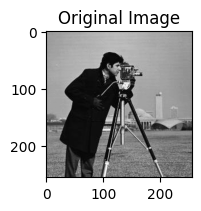

In [30]:
F = cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 3, 1)
plt.imshow(F, cmap='gray')
plt.title('Original Image')

In [31]:
# Convert to float
F = F.astype(np.float64) / 255.0

#### Hàm làm mờ (H(u,v))

In [32]:
H = np.zeros((21, 21))
H[10, :] = np.ones(21) 
H = H / np.sum(H) 

In [33]:
# Blur the image
F_multi_H = convolve2d(F, H, mode='same', boundary='wrap')

Text(0.5, 1.0, 'Blured Image')

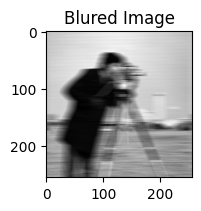

In [34]:
plt.subplot(1, 3, 1)
plt.imshow(F_multi_H, cmap='gray')
plt.title('Blured Image')

#### Hàm thêm gaussian noise


In [35]:
# Thêm nhiễu Gaussian
noise_mean = 0  # Giá trị trung bình của nhiễu
noise_var = 0.0001  # Phương sai của nhiễu
signal_var = np.var(F)  # Phương sai của tín hiệu (ảnh gốc)
NSR = noise_var / signal_var  # Tỷ lệ nhiễu tín hiệu (Noise-to-Signal Ratio)

In [36]:
# Generate noise and add to the blurred image
n = np.random.normal(noise_mean, np.sqrt(noise_var), F_multi_H.shape)
G = F_multi_H + n

Text(0.5, 1.0, 'Blurred + Noisy Image')

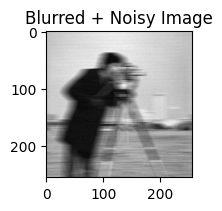

In [37]:
plt.subplot(1, 3, 2)
plt.imshow(G, cmap='gray')
plt.title('Blurred + Noisy Image')

### BỘ LỌC WIENER FILTER

In [38]:
# Wiener Deconvolution
def wiener_deconvolution(G, H, nsr):
    H = np.fft.fft2(H, s=G.shape)
    G = np.fft.fft2(G)

    # Calculate Wiener filter
    wiener_filter = (1/H) * (np.abs(H)**2 / (np.abs(H)**2 + nsr))

    # Apply Wiener filter
    F_prime = G * wiener_filter
    F_prime = np.fft.ifft2(F_prime)

    return np.abs(F_prime)

### KIỂM THỬ VỚI DỮ LIỆU ĐẦU VÀO

In [39]:
# Restore the image
F_prime = wiener_deconvolution(G, H, NSR)

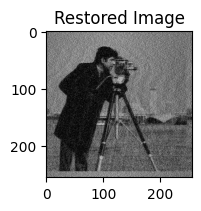

In [40]:
plt.subplot(1, 3, 3)
plt.imshow(F_prime, cmap='gray')
plt.title('Restored Image')

plt.show()

#### Hiển thị

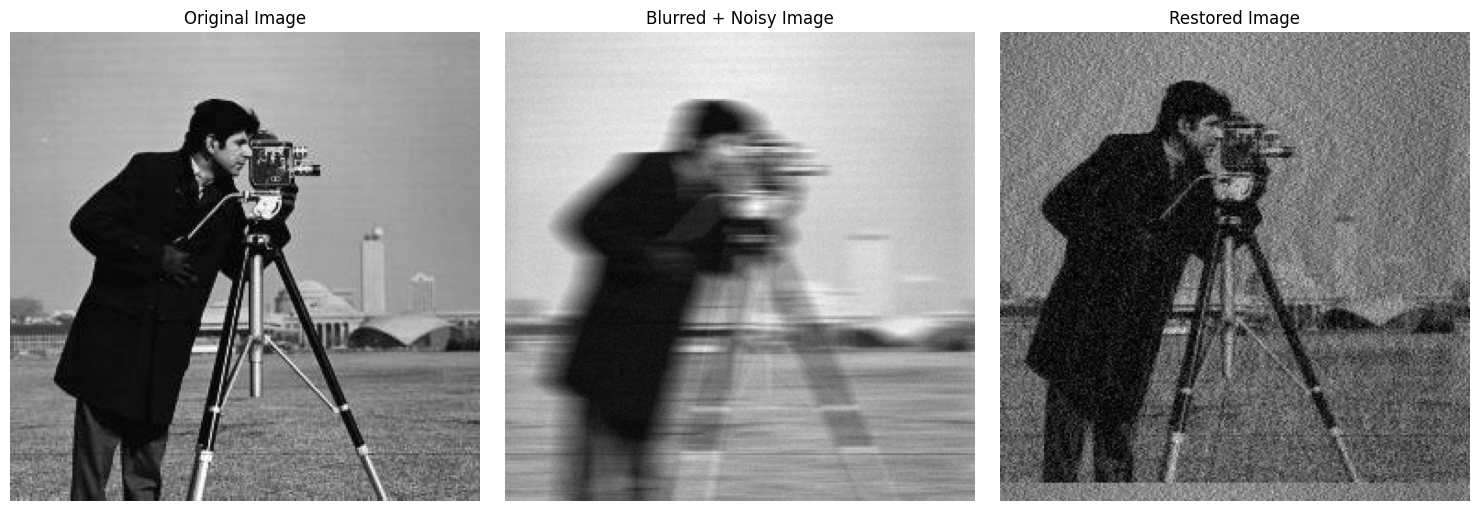

In [41]:
# Display images
show_images(F, G, F_prime)

#### Đánh giá 

In [42]:
# Tính MSE giữa ảnh đã cắt và ảnh đã khử nhiễu
mse_value = mse(F, F_prime)
snr_value = snr(F, F_prime)

print(f"MSE sau Wiener filter: {mse_value}")
print(f"\nSNR sau Wiener filter: {snr_value}")

MSE sau Wiener filter: 0.05450173476980134

SNR sau Wiener filter: 7.112284661786975


### Ứng dụng với một loạt các ảnh khác

In [43]:
# Thư mục chứa ảnh
data_dir = 'dataset/'
output_dir = 'dataset/output/'
os.makedirs(output_dir, exist_ok=True)

# Biến để tính tổng MSE và SNR
total_mse = 0
total_snr = 0
num_images = 0

# Đọc và xử lý từng ảnh trong thư mục data/
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".tif"):
        # Đọc ảnh dưới dạng grayscale
        filepath = os.path.join(data_dir, filename)
        F = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        # Chuyển đổi sang float
        F = F.astype(np.float64) / 255.0

        # Tạo PSF (motion blur) và blur ảnh
        F_multi_H = convolve2d(F, H, mode='same', boundary='wrap')

        # Thêm noise Gaussian vào ảnh đã blur
        n = np.random.normal(noise_mean, np.sqrt(noise_var), F_multi_H.shape)
        G = F_multi_H + n

        # Khôi phục ảnh bằng Wiener filter
        F_prime = wiener_deconvolution(G, H, NSR)

        # Tính MSE và SNR
        mse_value = mse(F, F_prime)
        snr_value = snr(F, F_prime)

        # Cập nhật tổng MSE và SNR
        total_mse += mse_value
        total_snr += snr_value
        num_images += 1

        # Lưu ảnh khôi phục
        output_filepath = os.path.join(
            output_dir, filename.split('.')[0] + '_prime.png')
        cv2.imwrite(output_filepath, (F_prime * 255).astype(np.uint8))

        # In số liệu
        with open(os.path.join(output_dir, "metrics.txt"), "a") as f:
            f.write(f"Image: {filename}\n")
            f.write(f"MSE: {mse_value}\n")
            f.write(f"SNR: {snr_value}\n")
            f.write("-" * 30 + "\n")

        print(f"Processed {filename}: MSE = {mse_value}, SNR = {snr_value}")

# Tính giá trị trung bình của MSE và SNR
if num_images > 0:
    avg_mse = total_mse / num_images
    avg_snr = total_snr / num_images
    print(f"\nAverage MSE: {avg_mse}")
    print(f"Average SNR: {avg_snr}")
else:
    print("No images processed.")

Processed 1.png: MSE = 0.03212368645435899, SNR = 7.808984306224069
Processed 10.png: MSE = 0.0449203730610482, SNR = 5.9983040660656
Processed 12.png: MSE = 0.042556106310296674, SNR = 8.054844755268496
Processed 13.png: MSE = 0.09240339859126298, SNR = 8.606117450707595
Processed 14.png: MSE = 0.05836592671781272, SNR = 7.275501033520191
Processed 3.png: MSE = 0.04324423492209322, SNR = 7.622650641728313
Processed 4.png: MSE = 0.035664335224630514, SNR = 8.749271821429737
Processed 5.png: MSE = 0.0780220450725242, SNR = 6.735614288867606
Processed 6.png: MSE = 0.03415674876989549, SNR = 6.272668570283763
Processed 7.png: MSE = 0.04757482589278767, SNR = 5.305009283455947
Processed 8.png: MSE = 0.043378170697984386, SNR = 10.561231026861018
Processed 9.png: MSE = 0.03853990812793574, SNR = 8.354102699314263

Average MSE: 0.04924581332021924
Average SNR: 7.612024995310551
